**TruncatedSVD** implements a variant of singular value decomposition *(SVD)* that only computes the  largest singular values, where  is a user-specified parameter.

Mathematically, truncated *SVD* Applied to traning samples $X$ produces a low.rank approcimation $X$:
$$X\approx X_K = U_k\Sigma_k V_k^T$$
After the operation, $U_k \Sigma_k$ is the transformed traning set with *k* features (called *n_components* in the API)
To also transform a test set $X$, we multiply it with $V_k$:
$$X' = XV_k$$

### Loading text data

We load data from The 20 newsgroups text dataset, which comprises around 18,000 newsgroups posts on 20 topics.

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


### Quantifying the quality of clustering results

In this section we define a function to score different clustering pipelines using several metrics.

In [2]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

### K-means clustering on text features
Two feature extraction methods are used in this example:
  - TfidfVectorizer
     - uses an in-memory vocabulary (a Python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.
  - HashingVectorizer
    - hashes word occurrences to a fixed dimensional space, possibly with collisions. The word count vectors are then normalized to each have l2-norm equal to one (projected to the euclidean unit-sphere) which seems to be important for k-means to work in high dimensional space.
Furthermore it is possible to post-process those extracted features using dimensionality reduction.

#### Feature Extraction using TfidfVectorizer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.228 s
n_samples: 3387, n_features: 7929


This is to gather unique terms in documents.

**max_df** - To eliminate terms that are present too often (set to 0.5 for 50\% of all documents)

**min_df** - To eliminate terms that are not present in at least 5 documents (set to 5 for nr. of documents)

**n_features** - The amount of unique terms $\approx 8000$

We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries devided by the total number of elements.

In [4]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.

### Clustering sparse data with k-means

As both KMeans and MiniBatchKMeans optimize a non-convex objective function, their clustering is not guaranteed to be optimal for a given random init. The following code illustrates how the previous phenomenon can sometimes lead to highly imbalanced clusters, depending on the random initialization:

In [5]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements asigned to each cluster: [   1    1 3384    1]
Number of elements asigned to each cluster: [1597  732  233  825]
Number of elements asigned to each cluster: [2004  446  646  291]
Number of elements asigned to each cluster: [1695  649  446  597]
Number of elements asigned to each cluster: [ 254 2117  459  557]

True number of documents in each category according to the class labels: [799 973 987 628]


To avoid this problem, one possibility is to increase the number of runs with independent random initiations n_init. In such case the clustering with the best inertia (objective function of k-means) is chosen.

In [6]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.16 ± 0.05 s 
Homogeneity: 0.336 ± 0.026
Completeness: 0.400 ± 0.008
V-measure: 0.365 ± 0.014
Adjusted Rand-Index: 0.202 ± 0.012
Silhouette Coefficient: 0.008 ± 0.001


All those clustering evaluation metrics have a maximum value of 1.0 (for a perfect clustering result). Higher values are better. Values of the Adjusted Rand-Index close to 0.0 correspond to a random labeling.

### Performing dimensionality reduction using LSA

A n_init=1 can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable. For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve the KMeans result. Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.576 s
Explained variance of the SVD step: 18.4%


Using a single initialization means the processing time will be reduced for both KMeans and MiniBatchKMeans.

In [8]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.10 ± 0.01 s 
Homogeneity: 0.407 ± 0.002
Completeness: 0.445 ± 0.016
V-measure: 0.425 ± 0.007
Adjusted Rand-Index: 0.322 ± 0.014
Silhouette Coefficient: 0.029 ± 0.001


We can observe that clustering on the LSA representation of the document is significantly faster (both because of n_init=1 and because the dimensionality of the LSA feature space is much smaller). Furthermore, all the clustering evaluation metrics have improved. We repeat the experiment with MiniBatchKMeans.

In [9]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.29 ± 0.25 s 
Homogeneity: 0.391 ± 0.007
Completeness: 0.397 ± 0.009
V-measure: 0.394 ± 0.007
Adjusted Rand-Index: 0.362 ± 0.038
Silhouette Coefficient: 0.027 ± 0.002


### Top terms per cluster

Since TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster. See the example script Classification of text documents using sparse features for a comparison with the most predictive words for each target class.

In [10]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: graphics thanks image program know file files looking help format 
Cluster 1: just think don like know time ve did does say 
Cluster 2: space launch orbit shuttle nasa earth moon like mission satellite 
Cluster 3: god people jesus believe bible don say think christian religion 


### HashingVectorizer

An alternative vectorization can be done using a HashingVectorizer instance, which does not provide IDF weighting as this is a stateless model (the fit method does nothing). When IDF weighting is needed it can be added by pipelining the HashingVectorizer output to a TfidfTransformer instance. In this case we also add LSA to the pipeline to reduce the dimension and sparcity of the hashed vector space.

In [11]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 1.789 s


One can observe that the LSA step takes a relatively long time to fit, especially with hashed vectors. The reason is that a hashed space is typically large (set to n_features=50_000 in this example). One can try lowering the number of features at the expense of having a larger fraction of features with hash collisions as shown in the example notebook FeatureHasher and DictVectorizer Comparison.

We now fit and evaluate the kmeans and minibatch_kmeans instances on this hashed-lsa-reduced data:

In [12]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.09 ± 0.01 s 
Homogeneity: 0.398 ± 0.012
Completeness: 0.448 ± 0.014
V-measure: 0.422 ± 0.013
Adjusted Rand-Index: 0.328 ± 0.010
Silhouette Coefficient: 0.030 ± 0.001


In [13]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.10 ± 0.01 s 
Homogeneity: 0.338 ± 0.060
Completeness: 0.348 ± 0.058
V-measure: 0.343 ± 0.059
Adjusted Rand-Index: 0.304 ± 0.065
Silhouette Coefficient: 0.024 ± 0.003


Both methods lead to good results that are similar to running the same models on the traditional LSA vectors (without hashing).

### Clustering evaluation summary

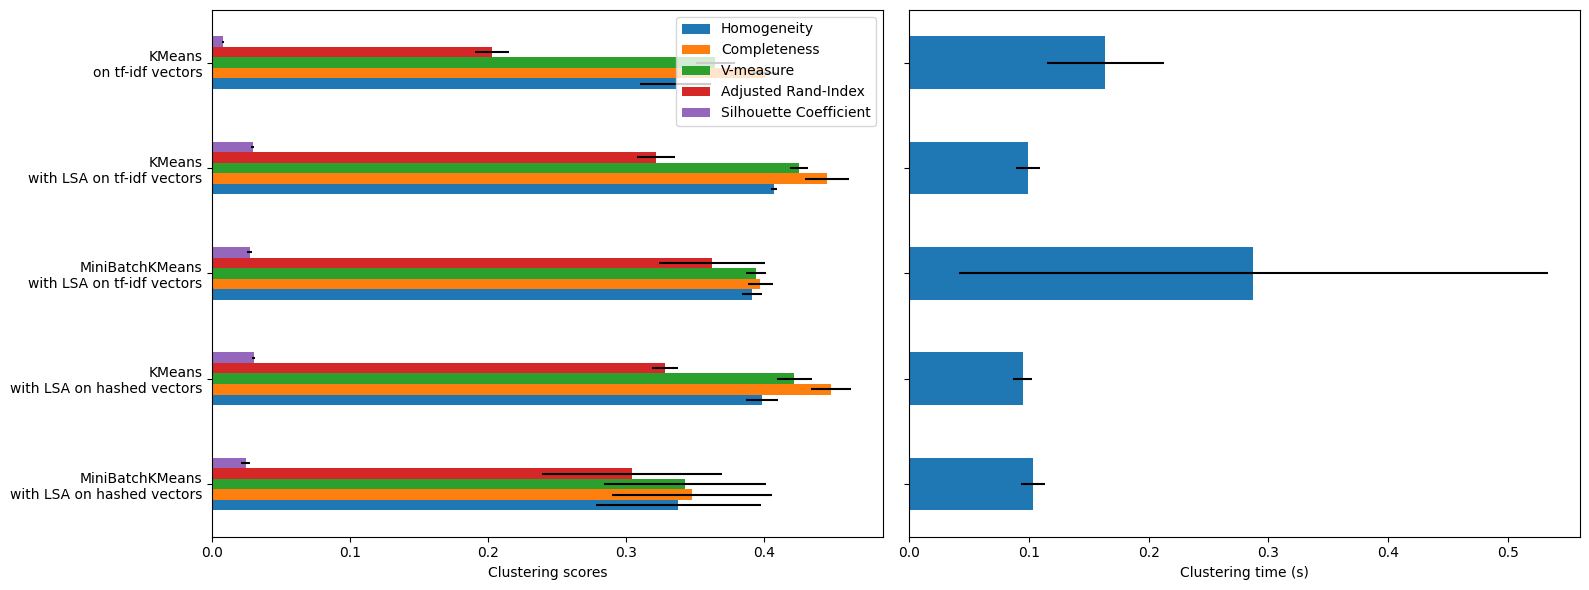

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()